#### Import everything you need

In [2]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import pickle
from keras.utils import to_categorical as make_class_categorical
from tqdm import tqdm

Using TensorFlow backend.


#### Set visualizer function

In [34]:
def visualize_plots(train, validation, display=False, title=None, save_name=None, save_path='../figures/'):
    """
    Visualization and saving plots (losses and accuracies) of the network.

    :param train: Loss of accuracy of the training data.
    :param validation: Loss of accuracy of the validation data.
    :param display: (Optional) Boolean, set to True for displaying the loss evolution plot.
    :param title: (Optional) Title of the plot.
    :param save_name: (Optional) name of the file to save the plot.
    :param save_path: (Optional) Path of the folder to save the plot in your local computer.

    :return: None

    """

    if title is not None:
        plt.title(title)

    plt.plot(train, 'g', label='Training set ')
    plt.plot(validation, 'r', label='Validation set')
    plt.legend(loc='upper right')

    if save_name is not None:
        if save_path[-1] != '/':
            save_path += '/'
        plt.savefig(save_path + save_name)

    if display:
        plt.show()

    plt.clf()

#### Load CIFAR-10

In [3]:
def LoadBatch(filename):
    """
    Loads batch based on the given filename and produces the X, Y, and y arrays

    :param filename: Path of the file
    :return: X, Y and y arrays
    """

    # borrowed from https://www.cs.toronto.edu/~kriz/cifar.html
    def unpickle(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

    dictionary = unpickle(filename)

    # borrowed from https://stackoverflow.com/questions/16977385/extract-the-nth-key-in-a-python-dictionary?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
    def ix(dic, n):  # don't use dict as  a variable name
        try:
            return list(dic)[n]  # or sorted(dic)[n] if you want the keys to be sorted
        except IndexError:
            print('not enough keys')

    garbage = ix(dictionary, 1)
    y = dictionary[garbage]
    Y = np.transpose(make_class_categorical(y, 10))
    garbage = ix(dictionary, 2)
    X = np.transpose(dictionary[garbage]) / 255

    return X, Y, y

In [4]:
def create_sets(folder_path='./'):
    """
    Creates the full dataset, containing all the available data for training except 1000 images
    used for the validation set.

    :return: Training, validation and test sets (features, ground-truth labels, and their one-hot representation
    """

    X_training_1, Y_training_1, y_training_1 = LoadBatch(f'{folder_path}/cifar-10-batches-py/data_batch_1')
    X_training_2, Y_training_2, y_training_2 = LoadBatch(f'{folder_path}/cifar-10-batches-py/data_batch_2')
    X_training_3, Y_training_3, y_training_3 = LoadBatch(f'{folder_path}/cifar-10-batches-py/data_batch_3')
    X_training_4, Y_training_4, y_training_4 = LoadBatch(f'{folder_path}/cifar-10-batches-py/data_batch_4')
    X_training_5, Y_training_5, y_training_5 = LoadBatch(f'{folder_path}/cifar-10-batches-py/data_batch_5')

    X_training = np.concatenate((X_training_1, X_training_3), axis=1)
    X_training = np.copy(np.concatenate((X_training, X_training_4), axis=1))
    X_training = np.copy(np.concatenate((X_training, X_training_5), axis=1))

    X_training = np.concatenate((X_training, X_training_2[:, :9000]), axis=1)

    Y_training = np.concatenate((Y_training_1, Y_training_3), axis=1)
    Y_training = np.copy(np.concatenate((Y_training, Y_training_4), axis=1))
    Y_training = np.copy(np.concatenate((Y_training, Y_training_5), axis=1))

    Y_training = np.concatenate((Y_training, Y_training_2[:, :9000]), axis=1)

    y_training = y_training_1 + y_training_3 + y_training_4 + y_training_5 + y_training_2[:9000]

    X_validation = np.copy(X_training_2[:, 9000:])
    Y_validation = np.copy(Y_training_2[:, 9000:])
    y_validation = y_training_2[9000:]

    X_test, Y_test, y_test = LoadBatch(f'{folder_path}cifar-10-batches-py/test_batch')

    mean = np.mean(X_training)
    X_training -= mean
    X_validation -= mean
    X_test -= mean

    return [X_training, Y_training, y_training], [X_validation, Y_validation, y_validation], [X_test, Y_test, y_test]

In [6]:
training_set, validation_set, test_set = create_sets(folder_path='../../')

In [7]:
X_training, Y_training, y_training = training_set
X_validation, Y_validation, y_validation = validation_set
X_test, Y_test, y_test = test_set

#### Set placeholders for weights and biases

In [9]:
weights = tf.Variable(tf.truncated_normal(shape=[Y_training.shape[0], X_training.shape[0]], stddev=0.01), name='weights') 
biases =  tf.Variable(tf.truncated_normal(shape=[Y_training.shape[0], 1], stddev=0.01), name='biases') 

#### Set placeholders for input and output data

In [10]:
X = tf.placeholder(tf.float32, [X_training.shape[0], None], name="Input")
Y = tf.placeholder(tf.float32, [Y_training.shape[0], None], name="One_hot_encoded_labels")

#### Define the computations requested for the output

In [12]:
z = tf.matmul(weights, X) 
z = tf.add(z, biases)
z = tf.nn.softmax(z, axis=0)

#### Define loss function

In [41]:
cross_entropy_loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(onehot_labels=Y, logits=z))

ValueError: Only call `softmax_cross_entropy_with_logits` with named arguments (labels=..., logits=..., ...)

#### Define the optimizer

In [14]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cross_entropy_loss)

#### Define the accuracy of the network

In [16]:
pred = tf.argmax(z, axis=0, name='predictions')
correct_labels = tf.argmax(Y, axis=0, name='true_labels')
correct_predictions = tf.equal(pred, correct_labels)
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name='accuracy')

#### Set MiniBatch gradient descent hyperaparameters

In [17]:
eta = 0.01
batch_size = 100
epoches = 100

#### Initialize the accumulators

In [18]:
training_set_loss_per_epoch, validation_set_loss_per_epoch = [], []
training_set_accuracy_per_epoch, validation_set_accuracy_per_epoch = [], []

### Training Session!

One last thing before training: Initialize the computation graph

In [21]:
init = tf.global_variables_initializer()

#### Train the model!

In [23]:
with tf.Session() as sess:
  
    sess.run(init)
    training_iterations_per_epoch = int(len(y_training) / batch_size)

    for epoch in tqdm(range(epoches)):

        for iteration in range(training_iterations_per_epoch):

            start = iteration * batch_size
            end = (iteration +1) * batch_size

            x_current = X_training[:, start:end]
            y_current = Y_training[:, start:end]

            feed_dict_current={
              X: x_current, 
              Y: y_current
            }

            sess.run([optimizer], feed_dict=feed_dict_current)

        training_loss, training_accuracy = sess.run([cross_entropy_loss, accuracy], feed_dict={X: X_training, Y:Y_training})
        val_loss, val_accuracy = sess.run([cross_entropy_loss, accuracy], feed_dict={X: X_validation, Y:Y_validation})

        training_set_loss_per_epoch.append(training_loss / X_training.shape[1])
        validation_set_loss_per_epoch.append(val_loss/ X_validation.shape[1])

        training_set_accuracy_per_epoch.append(round(training_accuracy* 100, 2))
        validation_set_accuracy_per_epoch.append(round(val_accuracy* 100, 2))

    test_set_accuracy = sess.run(accuracy, feed_dict={X: X_test, Y: Y_test})    

100%|██████████| 100/100 [08:15<00:00,  4.96s/it]


#### Visualize the loss evolution

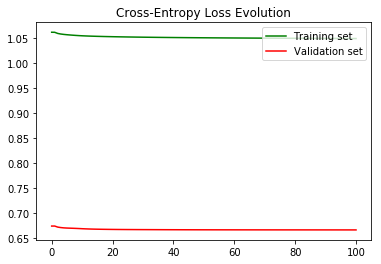

<Figure size 432x288 with 0 Axes>

In [38]:
visualize_plots(training_set_loss_per_epoch, validation_set_loss_per_epoch, title='Cross-Entropy Loss Evolution', display=True)

#### Accuracy performance evolution on training and validation sets

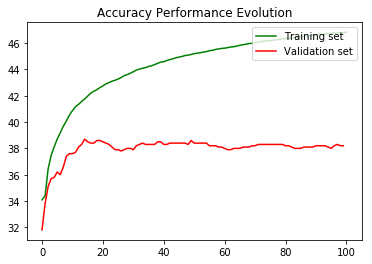

<Figure size 432x288 with 0 Axes>

In [37]:
visualize_plots(training_set_accuracy_per_epoch, validation_set_accuracy_per_epoch, title='Accuracy Performance Evolution', display=True)

In [33]:

type(training_set_accuracy_per_epoch)

list